In [1660]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from math import sin
from math import pi
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras import layers
from sklearn.metrics import mean_squared_error
from numpy import concatenate
from math import sqrt
from keras.optimizers import RMSprop
from keras import regularizers
from keras.layers import Dropout
from math import cos

In [992]:
warnings.simplefilter('ignore')

Считываем данные и посмотрим на них

In [993]:
data = pd.read_csv('products.csv', sep='|', error_bad_lines=False)

In [994]:
data.head()

,WEEK,PLN,PLN_LABEL,PRODUCT_CATEGORY,PRODUCT_CATEGORY_LABEL,OPSTUDY,OPSTUDY_LABEL,ACTUAL,BU,SEG,PROMO
0,1160529,40000223091,NIDO MILK PWDR NIDO FCRM 28.16OZ,006-108,ETHNIC,6,GENERAL GROCERIES,2,Consumables,B,N
1,1160529,40000223091,NIDO MILK PWDR NIDO FCRM 28.16OZ,006-108,ETHNIC,6,GENERAL GROCERIES,36,Consumables,C4,N
2,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,1198,Health/Wellness,A,Y
3,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,9,Health/Wellness,A,N
4,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,1479,Health/Wellness,C1,Y


In [995]:
def date_divide(x):
    x=x[1:]
    x='20' + x
    x=x[:4] + '-' + x[4:]
    x=x[:7] + '-' + x[7:]
    return x

In [996]:
aggregation = {
    'ACTUAL': 'sum',
    'PROMO': 'max',
    'YEAR': 'max',
    'MONTH': 'max',
    'DAY': 'max'
}

In [997]:
def cos_day(val):
    return cos(val*(2*pi)/31)

In [998]:
def cos_month(val):
    return cos(val*(2*pi)/12)

In [999]:
def sin_day(val):
    return sin(val*(2*pi)/31)

In [1000]:
def sin_month(val):
    return sin(val*(2*pi)/12)

Выберем определенный opstudy (например 51) и будем с ним работать

In [1001]:
opst_51 = data[data['OPSTUDY']==51].copy()

Удалим в новом датасете столбцы 'OPSTUDY', 'OPSTUDY_LABEL', 'BU', так как мы уже определились с opstudy; колонку 'SEG' удалим, так как она не очень информативна; также удалим все остальные описательные характеристики продуктов 

In [1002]:
opst_51.drop(['PLN_LABEL', 'PRODUCT_CATEGORY', 'PRODUCT_CATEGORY_LABEL', 'OPSTUDY', 'OPSTUDY_LABEL', 'BU', 'SEG'], axis=1, inplace=True)

Преобразуем наши данные в необходимые типы, а также приведем колонку 'WEEK' в нужный строковый тип при помощи функции date_divide, чтобы потом привести в дату

In [1003]:
opst_51['WEEK'] = opst_51['WEEK'].apply(lambda x: str(x))
opst_51['PLN'] = opst_51['PLN'].apply(lambda x: str(x))
opst_51['ACTUAL'] = opst_51['ACTUAL'].apply(lambda x: float(x))
opst_51['PROMO'] = opst_51['PROMO'].apply(lambda x: str(x))
opst_51['WEEK'] = opst_51['WEEK'].apply(lambda x: date_divide(x))

Приводим 'WEEK' в дату и создаем еще три колонки: год, месяц и день (неделю)

In [1004]:
opst_51['WEEK'] = pd.to_datetime(opst_51['WEEK'])
opst_51['YEAR'] = [d.year for d in opst_51['WEEK']]
opst_51['MONTH'] = [d.month for d in opst_51['WEEK']]
opst_51['DAY'] = [d.day for d in opst_51['WEEK']]

Создаем словарь и заменяем колонку 'PROMO' на числовые значения; кроме того в колонке часто встречаются пропуски, это связано с тем, что в наших данных встречаются для одних и тех же pln повторяющиеся недели. В таких случаях одно из значений будет 0 или 1 а другие nan. Заменим пока все nan на 0, а затем при агрегации будем брать максимум (если хотя бы в одной недели была 1, то значит 'PROMO' принимает значение 1)

In [1005]:
promo_dict = {'N':0, 'Y':1}
opst_51['PROMO'] = opst_51['PROMO'].replace(promo_dict)
opst_51['PROMO'] = opst_51['PROMO'].replace({'nan':0})

Проведем агрегацию данных по дате и pln

In [1006]:
opst_51 = opst_51.groupby(['WEEK', 'PLN'], as_index=False).agg(aggregation)

Возьмем первый попавшийся pln и сделаем отдельно для него прогноз

In [1007]:
first_pln = opst_51[opst_51['PLN']=='40000131497'].copy()

In [1008]:
first_pln.drop('PLN', axis=1, inplace=True)

Значения данных в зависимости от признака сильно разнятся, поэтому нормализируем наши данные о продажах

In [1009]:
scaler = MinMaxScaler()
scaler.fit(np.array(first_pln['ACTUAL']).reshape(-1, 1))
norm_act = scaler.transform(np.array(first_pln['ACTUAL']).reshape(-1, 1))
first_pln['ACTUAL'] = norm_act.ravel()

Приведем также признаки месяц и день к синусу и косинусу, располагая дни\месяца на тригонометрической окружности; признак 'YEAR' удалим

In [1010]:
first_pln.reset_index(inplace=True)
first_pln.set_index('WEEK', inplace=True)
first_pln.drop(['YEAR'], axis=1, inplace=True)
first_pln['MONTH_SIN'] = first_pln['MONTH'].apply(lambda m: sin_month(m))
first_pln['DAY_SIN'] = first_pln['DAY'].apply(lambda d: sin_day(d))
first_pln['MONTH_COS'] = first_pln['MONTH'].apply(lambda m: cos_month(m))
first_pln['DAY_COS'] = first_pln['DAY'].apply(lambda d: cos_day(d))
first_pln.reset_index('WEEK', inplace=True)
first_pln.drop('index', axis=1, inplace=True)

In [1011]:
first_pln.drop(['MONTH', 'DAY'], axis=1, inplace=True)

Взглянем на получившиеся данные

In [1012]:
first_pln.head()

,WEEK,ACTUAL,PROMO,MONTH_SIN,DAY_SIN,MONTH_COS,DAY_COS
0,2015-02-08,0.046961,0,0.866025,0.998717,5.000000e-01,-0.050649
1,2015-02-15,0.039595,0,0.866025,0.101168,5.000000e-01,-0.994869
2,2015-02-22,0.039595,0,0.866025,-0.968077,5.000000e-01,-0.250653
3,2015-03-01,0.033149,0,1.000000,0.201299,6.123234e-17,0.979530
4,2015-03-08,0.067219,0,1.000000,0.998717,6.123234e-17,-0.050649


Построим графики продаж и среднего за месяц

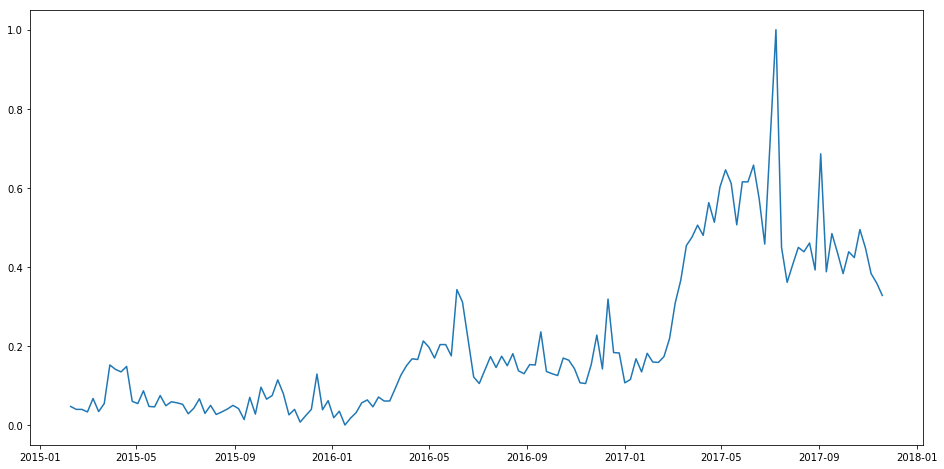

In [1013]:
plt.figure(figsize=(16,8))
plt.plot(first_pln['WEEK'], first_pln['ACTUAL'])
plt.show()

Графики дней и месяцев

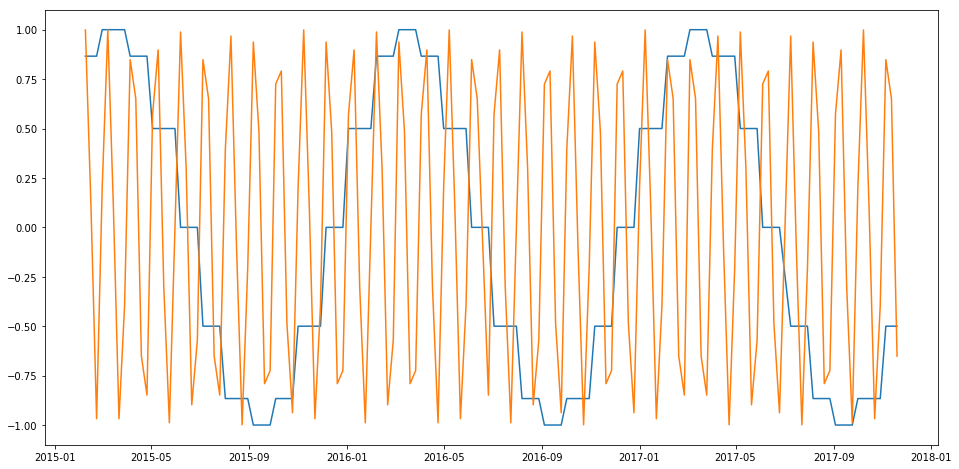

In [1014]:
plt.figure(figsize=(16,8))
plt.plot(first_pln['WEEK'], first_pln['MONTH_SIN'])
plt.plot(first_pln['WEEK'], first_pln['DAY_SIN'])
plt.show()

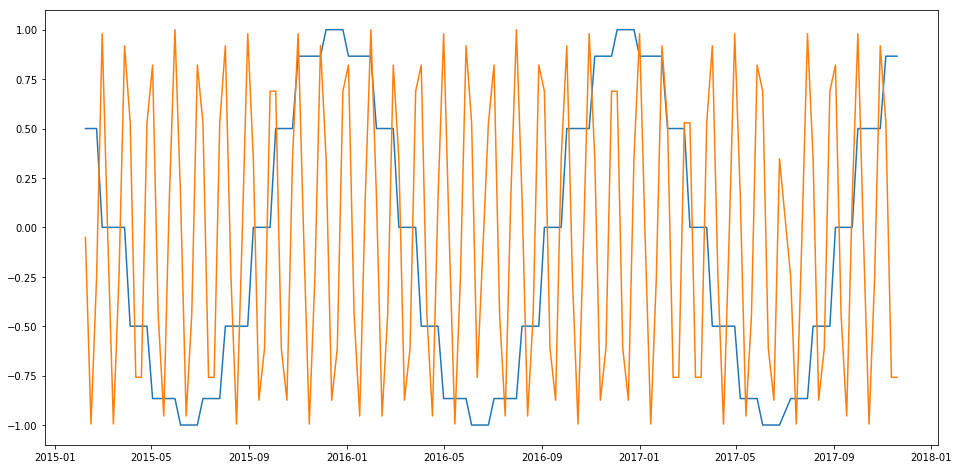

In [1015]:
plt.figure(figsize=(16,8))
plt.plot(first_pln['WEEK'], first_pln['MONTH_COS'])
plt.plot(first_pln['WEEK'], first_pln['DAY_COS'])
plt.show()

Поставим целевой признак в конец датасета

In [1016]:
act = first_pln['ACTUAL']
first_pln.drop('ACTUAL', axis=1, inplace = True)
first_pln.insert(6, 'ACTUAL', act)

In [1017]:
first_pln['WEEK'] = first_pln['WEEK'].apply(lambda x: str(x))

In [1018]:
first_pln.set_index('WEEK', inplace=True)

In [1019]:
first_pln.head()

,PROMO,MONTH_SIN,DAY_SIN,MONTH_COS,DAY_COS,ACTUAL
WEEK,,,,,,
2015-02-08 00:00:00,0,0.866025,0.998717,5.000000e-01,-0.050649,0.046961
2015-02-15 00:00:00,0,0.866025,0.101168,5.000000e-01,-0.994869,0.039595
2015-02-22 00:00:00,0,0.866025,-0.968077,5.000000e-01,-0.250653,0.039595
2015-03-01 00:00:00,0,1.000000,0.201299,6.123234e-17,0.979530,0.033149
2015-03-08 00:00:00,0,1.000000,0.998717,6.123234e-17,-0.050649,0.067219


Преобразуем еще немного наши данные, а именно измених их размерности (для того, чтобы скормить их нашей сети необходимо привести их к трехмерным тензорам); помимо этого разделим наш набор на тестовую и обучающую выборки

In [1802]:
lstm_data = first_pln.values

In [1803]:
train = lstm_data[:100, :]
test = lstm_data[100:, :]
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(100, 1, 5) (100,) (44, 1, 5) (44,)


Входным слоем нашей сети будет lstm слой, оптимизатор - RMSprop, для оценки ошибки возьмем среднюю абсолютную ошибку, в качестве валидационных данных возьмем тестовую выборку

In [1804]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(50, kernel_regularizer=regularizers.l2(0.02)))
model.add(Dense(1))
model.compile(loss='mae', optimizer=RMSprop())
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 100 samples, validate on 44 samples
Epoch 1/100
 - 5s - loss: 1.0275 - val_loss: 1.1985
Epoch 2/100
 - 0s - loss: 0.9345 - val_loss: 1.1260
Epoch 3/100
 - 0s - loss: 0.8606 - val_loss: 1.0654
Epoch 4/100
 - 0s - loss: 0.7972 - val_loss: 1.0061
Epoch 5/100
 - 0s - loss: 0.7406 - val_loss: 0.9532
Epoch 6/100
 - 0s - loss: 0.6869 - val_loss: 0.8975
Epoch 7/100
 - 0s - loss: 0.6401 - val_loss: 0.8567
Epoch 8/100
 - 0s - loss: 0.5920 - val_loss: 0.8090
Epoch 9/100
 - 0s - loss: 0.5496 - val_loss: 0.7662
Epoch 10/100
 - 0s - loss: 0.5091 - val_loss: 0.7259
Epoch 11/100
 - 0s - loss: 0.4721 - val_loss: 0.6906
Epoch 12/100
 - 0s - loss: 0.4366 - val_loss: 0.6607
Epoch 13/100
 - 0s - loss: 0.4028 - val_loss: 0.6283
Epoch 14/100
 - 0s - loss: 0.3715 - val_loss: 0.5951
Epoch 15/100
 - 0s - loss: 0.3445 - val_loss: 0.5702
Epoch 16/100
 - 0s - loss: 0.3179 - val_loss: 0.5446
Epoch 17/100
 - 0s - loss: 0.2931 - val_loss: 0.5210
Epoch 18/100
 - 0s - loss: 0.2712 - val_loss: 0.4994
Epoch 19/1

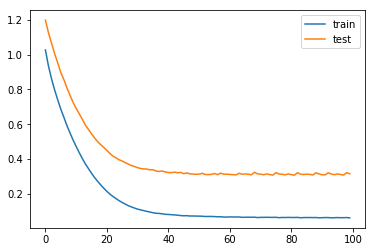

In [1805]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Найдем прогноз и посчитаем среднеквадратичную ошибку

In [1806]:
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat = concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 38.033


Графики предсказания и тестовой выборки

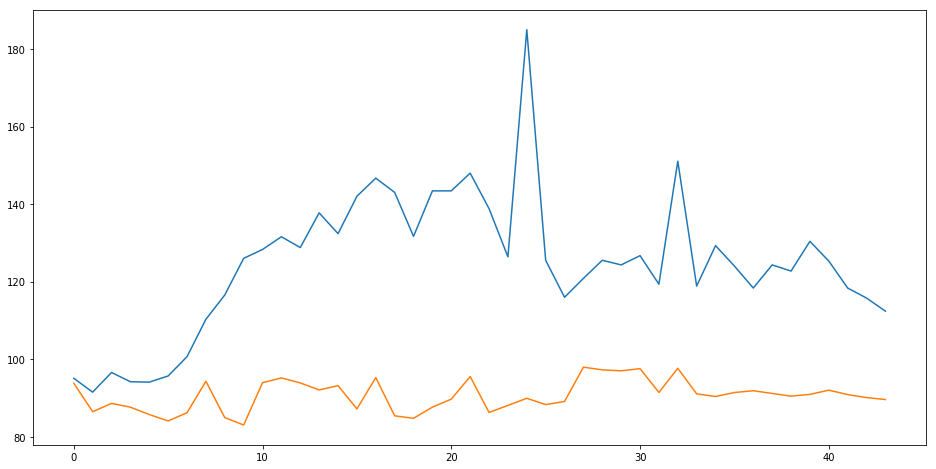

In [1807]:
plt.figure(figsize=(16,8))
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()

Возьмем какой-нибудь новый pln и построим для него другую сеть

In [1808]:
second_pln = opst_51[opst_51['PLN']=='40000131505'].copy()

In [1809]:
second_pln.drop('PLN', axis=1, inplace=True)

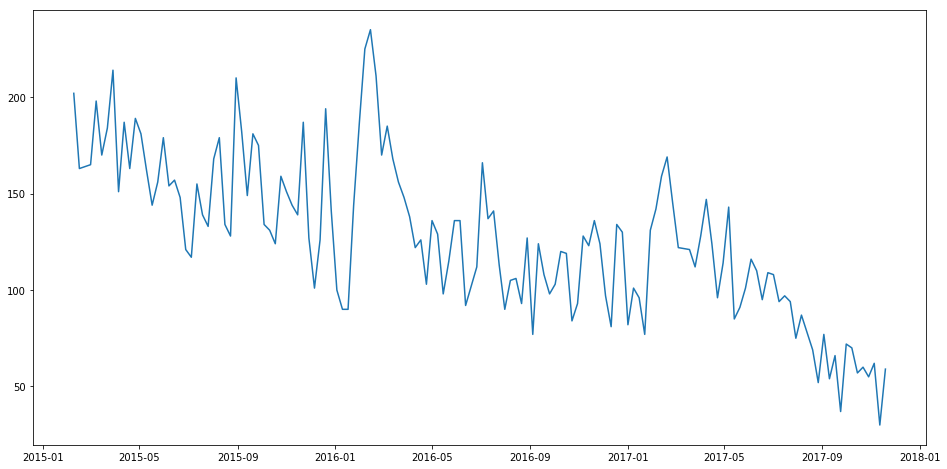

In [1810]:
plt.figure(figsize=(16,8))
plt.plot(second_pln['WEEK'], second_pln['ACTUAL'])
plt.show()

In [1811]:
second_pln

,WEEK,ACTUAL,PROMO,YEAR,MONTH,DAY
1,2015-02-08,202.0,0,2015,2,8
629,2015-02-15,163.0,0,2015,2,15
1257,2015-02-22,164.0,0,2015,2,22
1885,2015-03-01,165.0,0,2015,3,1
2511,2015-03-08,198.0,0,2015,3,8
3137,2015-03-15,170.0,0,2015,3,15
3758,2015-03-22,184.0,0,2015,3,22
4379,2015-03-29,214.0,0,2015,3,29
5000,2015-04-05,151.0,0,2015,4,5
5621,2015-04-12,187.0,0,2015,4,12


Поступим теперь иначе: а именно удалим все признаки кроме 'ACTUAL'. Тренировочный набор будет представлять данные по сути только за 2016 год и состоять из целевого признака - 'ACTUAL' и трех признаков - продажи соответственно в эту же неделю, но только за 2015 год и значения продаж 2 недель ранее в 2015 году; также добавим среднее значение продаж по этим трем неделям. Аналогично будет выглядеть тестовая выборка, но для 2016-2017 года (предсказания соответственно на 2017)

Так как наши данные начинаются с 2015-02-08, а заканчиваются на 2017-11-19, к тому же, учитывая тот факт, что мы берем еще предыдущие две недели, то будем делать предсказания только с марта по ноябрь

In [1812]:
second_pln.set_index('WEEK', inplace=True)

In [1813]:
df15 = second_pln[second_pln['YEAR']==2015].copy()

In [1814]:
df15.drop(['YEAR', 'PROMO'], axis=1, inplace=True)

In [1815]:
df16 = second_pln[second_pln['YEAR']==2016].copy()

In [1816]:
df16.drop(['YEAR', 'PROMO'], axis=1, inplace=True)

In [1817]:
df17 = second_pln[second_pln['YEAR']==2017].copy()

In [1818]:
df17.drop(['YEAR', 'PROMO'], axis=1, inplace=True)

In [1819]:
print(len(df15))
print(len(df16))
print(len(df17))

47
51
46


In [1820]:
df15.head()

,ACTUAL,MONTH,DAY
WEEK,,,
2015-02-08,202.0,2,8
2015-02-15,163.0,2,15
2015-02-22,164.0,2,22
2015-03-01,165.0,3,1
2015-03-08,198.0,3,8


In [1821]:
df15 = df15.ix[(df15['MONTH']!=1) & (df15['MONTH']!=2) & (df15['MONTH']!=12)]

In [1822]:
df16 = df16.ix[(df16['MONTH']!=1) & (df16['MONTH']!=2) & (df16['MONTH']!=12)]

In [1823]:
df17 = df17.ix[(df17['MONTH']!=1) & (df17['MONTH']!=2) & (df17['MONTH']!=12)]

In [1824]:
print(len(df15))
print(len(df16))
print(len(df17))

40
38
37


In [1825]:
df17

,ACTUAL,MONTH,DAY
WEEK,,,
2017-03-05,122.0,3,5
2017-03-19,121.0,3,19
2017-03-26,112.0,3,26
2017-04-02,128.0,4,2
2017-04-09,147.0,4,9
2017-04-16,124.0,4,16
2017-04-23,96.0,4,23
2017-04-30,114.0,4,30
2017-05-07,143.0,5,7


In [1826]:
df16

,ACTUAL,MONTH,DAY
WEEK,,,
2016-03-06,185.0,3,6
2016-03-13,168.0,3,13
2016-03-20,156.0,3,20
2016-03-27,148.0,3,27
2016-04-03,138.0,4,3
2016-04-10,122.0,4,10
2016-04-17,126.0,4,17
2016-04-24,103.0,4,24
2016-05-01,136.0,5,1


In [1827]:
df16.drop(df16.tail(1).index, inplace=True)

In [1828]:
df15

,ACTUAL,MONTH,DAY
WEEK,,,
2015-03-01,165.0,3,1
2015-03-08,198.0,3,8
2015-03-15,170.0,3,15
2015-03-22,184.0,3,22
2015-03-29,214.0,3,29
2015-04-05,151.0,4,5
2015-04-12,187.0,4,12
2015-04-19,163.0,4,19
2015-04-26,189.0,4,26


In [1829]:
df15.drop(df15.tail(2).index, inplace=True)
df15.drop(df15.head(1).index, inplace=True)

In [1830]:
print(len(df15))
print(len(df16))
print(len(df17))

37
37
37


In [1831]:
df15.drop(['MONTH', 'DAY'], axis=1, inplace=True)
df16.drop(['MONTH', 'DAY'], axis=1, inplace=True)
df17.drop(['MONTH', 'DAY'], axis=1, inplace=True)

In [1832]:
df16['FIRST'] = df15['ACTUAL'].values

In [1833]:
second = np.array([])
second = np.append(second, second_pln.loc['2015-03-01']['ACTUAL'])
second = np.append(second, df15.head(len(df15)-1)['ACTUAL'].values)

In [1834]:
df16['SECOND'] = second

In [1835]:
third = np.array([])
third = np.append(third, second_pln.loc['2015-02-22']['ACTUAL'])
third = np.append(third, second_pln.loc['2015-03-01']['ACTUAL'])
third = np.append(third, df15.head(len(df15)-2)['ACTUAL'].values)

In [1836]:
df16['THIRD'] = third

In [1837]:
df17['FIRST'] = df16['ACTUAL'].values

In [1838]:
second = np.array([])
second = np.append(second, second_pln.loc['2016-02-28']['ACTUAL'])
second = np.append(second, df16.head(len(df16)-1)['ACTUAL'].values)

In [1839]:
df17['SECOND'] = second

In [1840]:
third = np.array([])
third = np.append(third, second_pln.loc['2016-02-21']['ACTUAL'])
third = np.append(third, second_pln.loc['2016-02-28']['ACTUAL'])
third = np.append(third, df16.head(len(df16)-2)['ACTUAL'].values)

In [1841]:
df17['THIRD'] = third

In [1842]:
df16['MEAN'] = df16.loc[: , 'FIRST':'THIRD'].mean(axis=1)

In [1843]:
df17['MEAN'] = df17.loc[: , 'FIRST':'THIRD'].mean(axis=1)

In [1844]:
act = df16['ACTUAL']
df16.drop('ACTUAL', axis=1, inplace = True)
df16.insert(4, 'ACTUAL', act)

In [1845]:
act = df17['ACTUAL']
df17.drop('ACTUAL', axis=1, inplace = True)
df17.insert(4, 'ACTUAL', act)

In [1846]:
train = df16.values
test = df17.values

In [1847]:
scaler.fit(train)
train = scaler.transform(train)

In [1848]:
scaler.fit(test)
test = scaler.transform(test)

In [1849]:
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

In [1850]:
model = Sequential()
model.add(layers.Dense(32, input_shape=(X_train.shape[-1],)))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test))

Train on 37 samples, validate on 37 samples
Epoch 1/200
37/37 [==============================] - 5s 131ms/step - loss: 0.7015 - val_loss: 0.6417
Epoch 2/200
37/37 [==============================] - 0s 229us/step - loss: 0.5667 - val_loss: 0.5686
Epoch 3/200
37/37 [==============================] - 0s 283us/step - loss: 0.4814 - val_loss: 0.5034
Epoch 4/200
37/37 [==============================] - 0s 270us/step - loss: 0.4087 - val_loss: 0.4594
Epoch 5/200
37/37 [==============================] - 0s 270us/step - loss: 0.3687 - val_loss: 0.4455
Epoch 6/200
37/37 [==============================] - 0s 256us/step - loss: 0.3554 - val_loss: 0.4314
Epoch 7/200
37/37 [==============================] - 0s 283us/step - loss: 0.3405 - val_loss: 0.3966
Epoch 8/200
37/37 [==============================] - 0s 256us/step - loss: 0.3134 - val_loss: 0.3681
Epoch 9/200
37/37 [==============================] - 0s 256us/step - loss: 0.2931 - val_loss: 0.3471
Epoch 10/200
37/37 [===========================

Epoch 81/200
37/37 [==============================] - 0s 243us/step - loss: 0.1801 - val_loss: 0.2121
Epoch 82/200
37/37 [==============================] - 0s 270us/step - loss: 0.1791 - val_loss: 0.1919
Epoch 83/200
37/37 [==============================] - 0s 310us/step - loss: 0.1789 - val_loss: 0.1991
Epoch 84/200
37/37 [==============================] - 0s 270us/step - loss: 0.1779 - val_loss: 0.2126
Epoch 85/200
37/37 [==============================] - 0s 270us/step - loss: 0.1784 - val_loss: 0.2015
Epoch 86/200
37/37 [==============================] - 0s 256us/step - loss: 0.1769 - val_loss: 0.1959
Epoch 87/200
37/37 [==============================] - 0s 310us/step - loss: 0.1772 - val_loss: 0.2202
Epoch 88/200
37/37 [==============================] - 0s 310us/step - loss: 0.1794 - val_loss: 0.2091
Epoch 89/200
37/37 [==============================] - 0s 445us/step - loss: 0.1762 - val_loss: 0.1971
Epoch 90/200
37/37 [==============================] - 0s 283us/step - loss: 0.1761

37/37 [==============================] - 0s 270us/step - loss: 0.1691 - val_loss: 0.2058
Epoch 161/200
37/37 [==============================] - 0s 256us/step - loss: 0.1680 - val_loss: 0.2045
Epoch 162/200
37/37 [==============================] - 0s 243us/step - loss: 0.1670 - val_loss: 0.1890
Epoch 163/200
37/37 [==============================] - 0s 243us/step - loss: 0.1685 - val_loss: 0.2182
Epoch 164/200
37/37 [==============================] - 0s 256us/step - loss: 0.1705 - val_loss: 0.1856
Epoch 165/200
37/37 [==============================] - 0s 270us/step - loss: 0.1718 - val_loss: 0.1860
Epoch 166/200
37/37 [==============================] - 0s 324us/step - loss: 0.1705 - val_loss: 0.1997
Epoch 167/200
37/37 [==============================] - 0s 243us/step - loss: 0.1669 - val_loss: 0.1989
Epoch 168/200
37/37 [==============================] - 0s 256us/step - loss: 0.1679 - val_loss: 0.2233
Epoch 169/200
37/37 [==============================] - 0s 229us/step - loss: 0.1740 - v

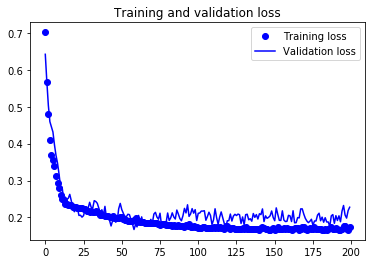

In [1851]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [1852]:
yhat = model.predict(X_test)

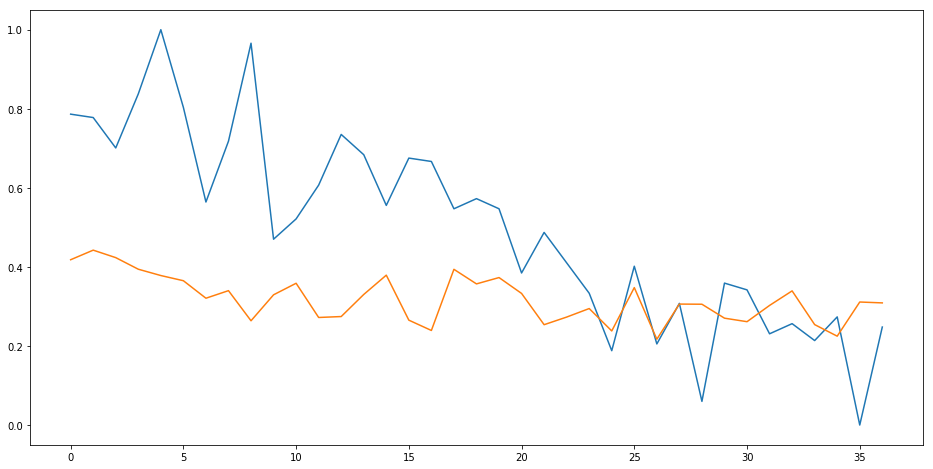

In [1853]:
plt.figure(figsize=(16,8))
plt.plot(y_test)
plt.plot(yhat)
plt.show()